In [1]:
%pylab inline
import time
import os 
import torch
from torch.autograd import Variable as V
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch import optim
#import torchvision
from torchvision import transforms
from PIL import Image
#from collections import OrderedDict

t0 = time.clock()

Populating the interactive namespace from numpy and matplotlib


# Model

In [2]:
## We use the pretrained model formation constructed by Gatys L. 
class VGG(nn.Module):
    def __init__(self, pool="max"):#
        super(VGG, self).__init__()
        ## vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]
    
## Load model
def model_loader(model_name):
    model = VGG()
    model.load_state_dict(torch.load(model_name))
    for param in model.parameters():
        param.requires_grad = False
    if torch.cuda.is_available():
        model.cuda()
    return model

# Image Processing

In [3]:
## We use the image preprocessing, postprocessing constructed by Gatys L. 
def preprocess(img_size,img):
    prep = transforms.Compose([transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), ##turn to BGR
                           transforms.Normalize(mean=[0.406, 0.456, 0.485], ##subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255))])
    return prep(img)

def postprocess(tensor):
    post1 = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.406, -0.456, -0.485], ##add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])])]) ##turn to RGB
    post2=transforms.Compose([transforms.ToPILImage()])
    t = post1(tensor).cpu()
    t[t>1] = 1    
    t[t<0] = 0
    img = post2(t)
    return img

def image_input(image_name):
    img_size=512 ##can be revised
    image=Image.open(image_name)
    image=preprocess(img_size,image)
    image=V(image).unsqueeze(0)
    if torch.cuda.is_available():
        image=image.cuda()
    return image

# Loss Function

In [4]:
## Gram Matrix and Loss
def gram_matrix(input):
    ## a=batch size(=1)
    a, c, h, w = input.size()  
    ## unrolled the matrix
    gram = input.view(a * c, h * w)  
    ## compute the gram product
    G = torch.mm(gram, gram.transpose(0,1))  
    ## the gram matrix is normalized by dividing by numbers of elements in each channel
    G = G.div_(h*w) 
    return G

class Stylell(nn.Module):
    def forward(self, input, target):
        out= torch.mean(torch.pow((gram_matrix(input)-gram_matrix(target)),2))
        if torch.cuda.is_available():
            out=out.cuda()
        return out
    
def content_matrix(input):
    a, c, h, w = input.size()  
    C = input.view(a * c, h * w)  
    return C

class Contentll(nn.Module):
    def forward(self, input, target):
        out= torch.mean(torch.pow((content_matrix(input)-content_matrix(target)),2))
        if torch.cuda.is_available():
            out=out.cuda()
        return out

def StyleLoss(layers,weights,style_img,generate_img,model):
    style_model=model(style_img,layers)
    style_targets = [i.detach() for i in style_model]
    generate_model=model(generate_img,layers)
    sloss=0
    for i,j in enumerate(generate_model):
        if torch.cuda.is_available():
            result=(weights[i]*Stylell()(j,style_targets[i]).cuda())
        else:
            result=(weights[i]*Stylell()(j,style_targets[i]))
        sloss=sloss+result
    return sloss

def ContentLoss(layers,weights,content_img,generate_img,model):
    content_model=model(content_img,layers)
    content_targets = [i.detach() for i in content_model]
    generate_model=model(generate_img,layers)
    closs=0
    for i,j in enumerate(generate_model):
        if torch.cuda.is_available():
            result=(weights[i]*Contentll()(j,content_targets[i]).cuda())
        else:
            result=(weights[i]*Contentll()(j,content_targets[i]))
        closs=closs+result
    return closs


def total_loss(loss_s,loss_c,hp): 
    ## hp=hyperparameter list [hp for loss_s, hp for loss_c]
    loss=loss_s*hp[0]+loss_c*hp[1]
    return loss

# Model Iteration Run

In [5]:
def iteration_run(N,show_iter,style_img,content_img,model):
    
    ##random init
    ##generate = V(torch.randn(content_img.size()).type_as(content_img.data), requires_grad=True) 
    generate = V(content_img.data.clone(), requires_grad=True)
    if torch.cuda.is_available():
        generate=generate.cuda()
   
    style_layers = ['r11','r21','r31','r41', 'r51'] 
    content_layers = ['r42']

    style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
    content_weights = [1]  

    hyper=[1,1]
    current=[0]
    optimizer = optim.LBFGS([generate])
    
    while current[0] <= N:
        def optima():
            optimizer.zero_grad()
            loss_s=StyleLoss(style_layers,style_weights,style_img,generate,model)
            loss_c=ContentLoss(content_layers,content_weights,content_img,generate,model)
            loss=total_loss(loss_s,loss_c,hyper)
            loss.backward()
            current[0]+=1
            #print loss
            if current[0]%show_iter == (show_iter-1):
                print('Iteration: %d, loss: %f'%(current[0]+1, loss.data[0]))
            return loss
        optimizer.step(optima)
    return generate

# Result

In [6]:
#Run style transfer
vgg=model_loader('vgg_conv.pth')
style=image_input("vango.jpg")
content=image_input("tubingen.jpg")

max_iter = 5
show_iter= 5

generate=iteration_run(max_iter,show_iter,style,content,vgg)


/home/shulincao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iteration: 5, loss: 342729248.000000
Iteration: 10, loss: 55196432.000000
Iteration: 15, loss: 17092684.000000
Iteration: 20, loss: 8933261.000000


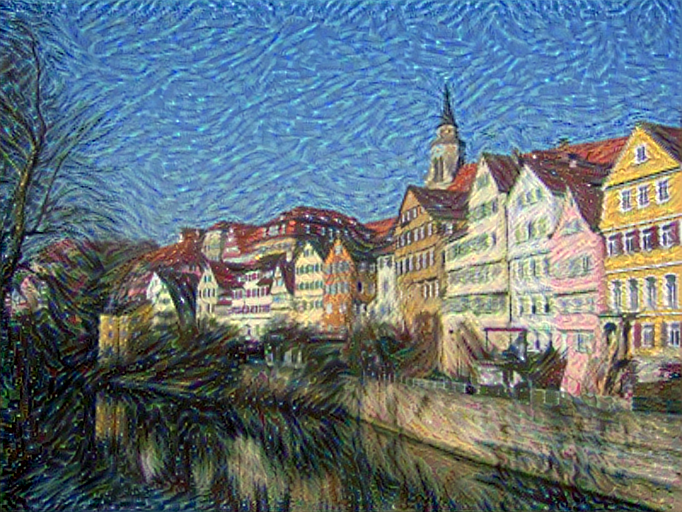

8.689625999999999 seconds process time


In [8]:
##Display result
g_img = postprocess(generate.data[0].squeeze())
display(g_img)
print(time.clock() - t0, "seconds process time")
